In [57]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import itertools
import pickle

from matplotlib import rcParams
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
rcParams['figure.figsize'] = 12, 5
plt.rcParams.update({'font.size': 15})
plotsize = (10, 6)
legend_size = 12
rcParams["savefig.dpi"] = 300
rcParams["savefig.bbox"] = 'tight'

In [41]:
# def fit_function(x, central_flux, flux_quanta, di, EjEc):
#     phi_e = (x - central_flux) / flux_quanta
#     return(np.sqrt(8 * EjEc * Ej(di, phi_e)))
Ec_ = 0.08

def fit_function(x, *fit_params):
    phi_e = (x - fit_params[0]) / fit_params[1]
    return(np.sqrt(8 * fit_params[3] * Ec_ * Ej(fit_params[2], phi_e)) - Ec_)

def linear_function(x, v0, slope):
    return(x * slope + v0)
def linear_fit_function(frequencies, points, guess):
    fit_params, pCov = curve_fit(linear_function, frequencies, points, p0=guess, maxfev=100000)
    return(fit_params)
def curve_fit_function(frequencies, points, guess):
    fit_params, pCov = curve_fit(fit_function, frequencies, points, p0=guess, maxfev=100000)
    return(fit_params)

def peak_maxima(Voltage, Frequency, Amplitude, list_of_guesses, span, step_size = None, start_ = 0, end_ = None):
    central_flux, flux_quanta, di, EjEc = list_of_guesses
    if step_size == None:
        step_size = step_size = Frequency[:, 0][1] - Frequency[:, 0][0]
    number_of_points = int(span // (step_size * 1e3))
    
    Voltage = Voltage[0]
    Frequency = Frequency[:, 0]
    Amplitude = Amplitude
    
    frequency_maxima = []
    
    for i in range(len(Voltage[start_: end_])):
        volt = Voltage[i + start_]
        frequency_center = fit_function(volt, central_flux, flux_quanta, di, EjEc)
        index = find_central(frequency_center, Frequency)
        filtered_amplitude = savgol_filter(Amplitude[:, i + start_], 7, 1)
        minimum_freq_bound = max(0, index - number_of_points)
        maximum_frequency = np.argmax(filtered_amplitude[minimum_freq_bound: index + number_of_points])
        frequency_maxima.append(Frequency[maximum_frequency + minimum_freq_bound])
    return(frequency_maxima)

def peak_max_linearInitial(Voltage, Frequency, Amplitude, list_of_guesses, span, step_size = None, start_ = 0, end_ = None):
    v0, slope = list_of_guesses
    if step_size == None:
        step_size = step_size = Frequency[:, 0][1] - Frequency[:, 0][0]
    number_of_points = int(span // (step_size * 1e3))
    
    Voltage = Voltage[0]
    Frequency = Frequency[:, 0]
    Amplitude = Amplitude
    
    frequency_maxima = []
    for i in range(len(Voltage[start_: end_])):
        volt = Voltage[i + start_]
        frequency_center = linear_function(volt, v0, slope)
        index = find_central(frequency_center, Frequency)
        filtered_amplitude = savgol_filter(Amplitude[:, i + start_], 7, 1)
        minimum_freq_bound = max(0, index - number_of_points)
        maximum_frequency = np.argmax(filtered_amplitude[minimum_freq_bound: index + number_of_points])
        frequency_maxima.append(Frequency[maximum_frequency + minimum_freq_bound])
    return(frequency_maxima)

def peak_max_linear(Voltage, Frequency, Amplitude,  start_ = 0, end_ = None):
    Voltage = Voltage[0]
    Frequency = Frequency[:, 0]
    Amplitude = Amplitude
    
    frequency_maxima = []
    for i in range(len(Voltage[start_: end_])):
        volt = Voltage[i + start_]
        filtered_amplitude = savgol_filter(Amplitude[:, i + start_], 7, 1)
        maximum_frequency = np.argmax(filtered_amplitude)
        frequency_maxima.append(Frequency[maximum_frequency])
    return(frequency_maxima)

def find_central(value, array):
    updated_array = array - value
    updated_array = updated_array**2
    return(np.argmin(updated_array))

def imshow(X, Y, Z, vmin = -2, vmax = 10):
    step = X[0][1] - X[0][0]
    ax_plot = ax.imshow(
                Z, 
                'summer', 
                aspect='auto', 
                extent=[np.min(X) - step / 2,np.max(X)+ step / 2,np.min(Y),np.max(Y)],
                vmin = vmin, vmax = vmax, origin='lower', interpolation = 'none'
    )
    
def Ej(d, phiext):
    '''
    phiext is in units of flux quanta
    '''
    return(1 * np.sqrt((np.cos(np.pi * phiext))**2 + d**2 * (np.sin(np.pi * phiext)**2)))

def ResonatorFrequency_QubitParams(flux, w0, coupling, EcEj, d):
    return(w0 + coupling / (w0 - freq(flux, EcEj, d)))

def ResonatorFrequency(qubit_freq, w0, coupling):
    return(w0 + coupling / (w0 - qubit_freq))

def d(Ej1, Ej2):
    return((Ej1 - Ej2) / (Ej1 + Ej2))

def get_data(filename):
    data1 = loadmat(filename)
    transAmpData1 = data1['transamp']
    specAmpData1 = data1['specamp']
    specPhaseData1 = data1['specphase']
    specFreqVector1 = data1['specfreq']
    volts1 = data1['voltage_vector']

    Ylist = specFreqVector1
    Xlist0 = volts1
    Xlist = Xlist0

    Xlist = np.asarray(Xlist)
    Ylist = np.asarray(Ylist)*1e-9

    # Xlist = (Xlist - voltOffSet +VoltPerFlux*center)/VoltPerFlux

    X,Y = np.meshgrid(Xlist,Ylist)

    ### make copies of spec data 
    phase = specPhaseData1.copy()
    amp = specAmpData1.copy()

    ### remove average for better plotting
    for i in range(0, len(phase[:,1]) ):
        phase[i,:] = phase[i,:] - np.mean(phase[i,:])
        amp[i,:] = amp[i,:] - np.mean(amp[i,:])
    amp = amp#[::-1]
    Z = amp.copy()
    Z = np.asarray(Z)
    Z = np.transpose(Z)
    
    return(X, Y, Z)

def freq(phi, offset, d):
    return(np.sqrt(offset * np.sqrt(np.cos(np.pi * phi) ** 2 + d**2 * np.sin(np.pi * phi)**2)))
def freq(phi, EcEj, d, Ec = 0.1):
    return(np.sqrt(8 * EcEj * np.sqrt(d**2 + np.cos(np.pi * phi) **2 * (1 - d**2))) )
def freq(phi, Ej_, d, Ec_ = Ec_):
    return(np.sqrt(8 * Ec_ * Ej_ * np.sqrt(d**2 + np.cos(np.pi * phi) **2 * (1 - d**2))) - Ec_)
def flux(frequency, offset, d):
    offset *= 8
    numerator = np.sqrt((frequency ** 4) / (offset ** 2) - d **2)
    denominator = np.sqrt(1 - d ** 2)
    return np.arccos(numerator / denominator) / np.pi    

def fit_parameters(initial_guesses, list_of_x, list_of_y, list_of_z, list_of_start, 
                   list_of_end, spans = [500, 50], print_figures = True, voltage_numbers = 200):
    '''
    Initial_guesses should be [central_flux, flux_quanta, di, EjEc]
    '''    
    concatenated_x = []
    minimum_x = np.inf
    maximum_x = -np.inf
    for i in range(len(list_of_x)):
        start_index, end_index = list_of_start[i], list_of_end[i]
        concatenated_x.append(list_of_x[i][0][start_index: end_index])
        
        min_x = min(list_of_x[i][0])
        max_x = max(list_of_x[i][0])
        if min_x < minimum_x:
            minimum_x = min_x
        if max_x > maximum_x:
            maximum_x = max_x
            
    voltage_axis = np.linspace(minimum_x, maximum_x, voltage_numbers)
    concatenated_x = np.concatenate(tuple(concatenated_x))
        

    for span in spans:
        frequency_maxima_total = []
        for i in range(len(list_of_x)):
            start_index, end_index = list_of_start[i], list_of_end[i]
            X, Y, Z = list_of_x[i], list_of_y[i], list_of_z[i]
            if span == spans[0]:
                initial_guess = initial_guesses
            else:
                initial_guess = fit_params
            frequency_maxima = peak_maxima(X, Y, Z, initial_guess, span, start_ = start_index, end_ = end_index)
            frequency_maxima_total += frequency_maxima
        fit_params = curve_fit_function(concatenated_x, frequency_maxima_total, 
                          guess= initial_guess)
        
        if print_figures:
            fig = plt.figure(10, figsize=[10, 6])
            ax = fig.add_subplot(111)
            ax.plot(concatenated_x, frequency_maxima_total, '.')
            ax.plot(voltage_axis, [fit_function(v, fit_params) 
                                                               for v in voltage_axis])

            plt.show()
        print(fit_params)
        
    return(fit_params)
        
            
def voltage_axis_generator(list_of_x, voltage_numbers = 200):
    minimum_x = np.inf
    maximum_x = -np.inf
    for i in range(len(list_of_x)):        
        min_x = min(list_of_x[i][0])
        max_x = max(list_of_x[i][0])
        if min_x < minimum_x:
            minimum_x = min_x
        if max_x > maximum_x:
            maximum_x = max_x
    
    voltage_axis = np.linspace(minimum_x, maximum_x, voltage_numbers)
    return(voltage_axis)

def Peak_Max_Finder(Voltage, Frequency, Amplitude,  start_ = 0, end_ = None):
    Voltage = Voltage[0]
    Frequency = Frequency[:, 0]
    Amplitude = Amplitude
    
    frequency_maxima = []
    for i in range(len(Voltage[start_: end_])):
        volt = Voltage[i + start_]
        filtered_amplitude = savgol_filter(Amplitude[:, i + start_], 7, 1)
        maximum_frequency = np.argmax(filtered_amplitude)
        frequency_maxima.append(Frequency[maximum_frequency])
    return(frequency_maxima)


# First, concatenate all of the files together if multiple, 
# then find maximum at each point
# then apply fit function to this. 

def Initial_Guesses(list_of_x, list_of_y, list_of_z, list_of_start = [0], list_of_end = [None], di_guess = 0.5, EjEc_guess = 20):
    frequency_maxima_total = []
    all_voltages = []
    for i in range(len(list_of_x)):
        start_index, end_index = list_of_start[i], list_of_end[i]
        X, Y, Z = list_of_x[i], list_of_y[i], list_of_z[i]
        frequency_maxima = Peak_Max_Finder(X, Y, Z, start_ = start_index, end_ = end_index)
        frequency_maxima_total += frequency_maxima

        all_voltages += list(list_of_x[i][0])
        
    max_voltage = all_voltages[np.argmax(frequency_maxima_total)]
    min_voltage = all_voltages[np.argmin(frequency_maxima_total)]

    fit_params = curve_fit_function(all_voltages, frequency_maxima_total, 
                      guess= [max_voltage, 2 * np.abs(max_voltage - min_voltage), di_guess, EjEc_guess])
    return(fit_params, frequency_maxima_total, all_voltages)

In [108]:
# def fit_function(x, central_flux, flux_quanta, di, EjEc):
#     phi_e = (x - central_flux) / flux_quanta
#     return(np.sqrt(8 * EjEc * Ej(di, phi_e)))
Ec_ = 0.08

def fit_function(x, central_flux, flux_quanta, di, Ej_):
    phi_e = (x - central_flux) / flux_quanta
    return(np.sqrt(8 * Ej_ * Ec_ * Ej(di, phi_e)) - Ec_)
def linear_function(x, v0, slope):
    return(x * slope + v0)
def linear_fit_function(frequencies, points, guess):
    fit_params, pCov = curve_fit(linear_function, frequencies, points, p0=guess, maxfev=100000)
    return(fit_params)
def curve_fit_function(frequencies, points, guess):
    fit_params, pCov = curve_fit(fit_function, frequencies, points, p0=guess, maxfev=100000)
    return(fit_params)

def peak_maxima(Voltage, Frequency, Amplitude, list_of_guesses, span, step_size = None, start_ = 0, end_ = None):
    central_flux, flux_quanta, di, EjEc = list_of_guesses
    if step_size == None:
        step_size = step_size = Frequency[:, 0][1] - Frequency[:, 0][0]
    number_of_points = int(span // (step_size * 1e3))
    
    Voltage = Voltage[0]
    Frequency = Frequency[:, 0]
    Amplitude = Amplitude
    
    frequency_maxima = []
    
    for i in range(len(Voltage[start_: end_])):
        volt = Voltage[i + start_]
        frequency_center = fit_function(volt, central_flux, flux_quanta, di, EjEc)
        index = find_central(frequency_center, Frequency)
        filtered_amplitude = savgol_filter(Amplitude[:, i + start_], 7, 1)
        minimum_freq_bound = max(0, index - number_of_points)
        maximum_frequency = np.argmax(filtered_amplitude[minimum_freq_bound: index + number_of_points])
        frequency_maxima.append(Frequency[maximum_frequency + minimum_freq_bound])
    return(frequency_maxima)

def peak_max_linearInitial(Voltage, Frequency, Amplitude, list_of_guesses, span, step_size = None, start_ = 0, end_ = None):
    v0, slope = list_of_guesses
    if step_size == None:
        step_size = step_size = Frequency[:, 0][1] - Frequency[:, 0][0]
    number_of_points = int(span // (step_size * 1e3))
    
    Voltage = Voltage[0]
    Frequency = Frequency[:, 0]
    Amplitude = Amplitude
    
    frequency_maxima = []
    for i in range(len(Voltage[start_: end_])):
        volt = Voltage[i + start_]
        frequency_center = linear_function(volt, v0, slope)
        index = find_central(frequency_center, Frequency)
        filtered_amplitude = savgol_filter(Amplitude[:, i + start_], 7, 1)
        minimum_freq_bound = max(0, index - number_of_points)
        maximum_frequency = np.argmax(filtered_amplitude[minimum_freq_bound: index + number_of_points])
        frequency_maxima.append(Frequency[maximum_frequency + minimum_freq_bound])
    return(frequency_maxima)

def peak_max_linear(Voltage, Frequency, Amplitude,  start_ = 0, end_ = None):
    Voltage = Voltage[0]
    Frequency = Frequency[:, 0]
    Amplitude = Amplitude
    
    frequency_maxima = []
    for i in range(len(Voltage[start_: end_])):
        volt = Voltage[i + start_]
        filtered_amplitude = savgol_filter(Amplitude[:, i + start_], 7, 1)
        maximum_frequency = np.argmax(filtered_amplitude)
        frequency_maxima.append(Frequency[maximum_frequency])
    return(frequency_maxima)

def find_central(value, array):
    updated_array = array - value
    updated_array = updated_array**2
    return(np.argmin(updated_array))

def imshow(X, Y, Z, vmin = -2, vmax = 10):
    step = X[0][1] - X[0][0]
    ax_plot = ax.imshow(
                Z, 
                'summer', 
                aspect='auto', 
                extent=[np.min(X) - step / 2,np.max(X)+ step / 2,np.min(Y),np.max(Y)],
                vmin = vmin, vmax = vmax, origin='lower', interpolation = 'none'
    )
    
def Ej(d, phiext):
    '''
    phiext is in units of flux quanta
    '''
    return(1 * np.sqrt((np.cos(np.pi * phiext))**2 + d**2 * (np.sin(np.pi * phiext)**2)))

def ResonatorFrequency_QubitParams(flux, w0, coupling, EcEj, d):
    return(w0 + coupling / (w0 - freq(flux, EcEj, d)))

def ResonatorFrequency(qubit_freq, w0, coupling):
    return(w0 + coupling / (w0 - qubit_freq))

def d(Ej1, Ej2):
    return((Ej1 - Ej2) / (Ej1 + Ej2))

def get_data(filename):
    data1 = loadmat(filename)
    transAmpData1 = data1['transamp']
    specAmpData1 = data1['specamp']
    specPhaseData1 = data1['specphase']
    specFreqVector1 = data1['specfreq']
    volts1 = data1['voltage_vector']

    Ylist = specFreqVector1
    Xlist0 = volts1
    Xlist = Xlist0

    Xlist = np.asarray(Xlist)
    Ylist = np.asarray(Ylist)*1e-9

    # Xlist = (Xlist - voltOffSet +VoltPerFlux*center)/VoltPerFlux

    X,Y = np.meshgrid(Xlist,Ylist)

    ### make copies of spec data 
    phase = specPhaseData1.copy()
    amp = specAmpData1.copy()

    ### remove average for better plotting
    for i in range(0, len(phase[:,1]) ):
        phase[i,:] = phase[i,:] - np.mean(phase[i,:])
        amp[i,:] = amp[i,:] - np.mean(amp[i,:])
    amp = amp#[::-1]
    Z = amp.copy()
    Z = np.asarray(Z)
    Z = np.transpose(Z)
    
    return(X, Y, Z)

def freq(phi, offset, d):
    return(np.sqrt(offset * np.sqrt(np.cos(np.pi * phi) ** 2 + d**2 * np.sin(np.pi * phi)**2)))
def freq(phi, EcEj, d, Ec = 0.1):
    return(np.sqrt(8 * EcEj * np.sqrt(d**2 + np.cos(np.pi * phi) **2 * (1 - d**2))) )
def freq(phi, Ej_, d, Ec_ = Ec_):
    return(np.sqrt(8 * Ec_ * Ej_ * np.sqrt(d**2 + np.cos(np.pi * phi) **2 * (1 - d**2))) - Ec_)
def flux(frequency, offset, d):
    offset *= 8
    numerator = np.sqrt((frequency ** 4) / (offset ** 2) - d **2)
    denominator = np.sqrt(1 - d ** 2)
    return np.arccos(numerator / denominator) / np.pi    

def fit_parameters(initial_guesses, list_of_x, list_of_y, list_of_z, list_of_start, 
                   list_of_end, spans = [500, 50], print_figures = True, voltage_numbers = 200, 
                  return_freqs = False):
    '''
    Initial_guesses should be [central_flux, flux_quanta, di, EjEc]
    '''    
    concatenated_x = []
    minimum_x = np.inf
    maximum_x = -np.inf
    for i in range(len(list_of_x)):
        start_index, end_index = list_of_start[i], list_of_end[i]
        concatenated_x.append(list_of_x[i][0][start_index: end_index])
        
        min_x = min(list_of_x[i][0])
        max_x = max(list_of_x[i][0])
        if min_x < minimum_x:
            minimum_x = min_x
        if max_x > maximum_x:
            maximum_x = max_x
            
    voltage_axis = np.linspace(minimum_x, maximum_x, voltage_numbers)
    concatenated_x = np.concatenate(tuple(concatenated_x))
        

    for span in spans:
        frequency_maxima_total = []
        for i in range(len(list_of_x)):
            start_index, end_index = list_of_start[i], list_of_end[i]
            X, Y, Z = list_of_x[i], list_of_y[i], list_of_z[i]
            if span == spans[0]:
                initial_guess = initial_guesses
            else:
                initial_guess = fit_params
            frequency_maxima = peak_maxima(X, Y, Z, initial_guess, span, start_ = start_index, end_ = end_index)
            frequency_maxima_total += frequency_maxima
    
        fit_params = curve_fit_function(concatenated_x, frequency_maxima_total, 
                          guess= initial_guess)
        
        if print_figures:
            fig = plt.figure(10, figsize=[10, 6])
            ax = fig.add_subplot(111)
            ax.plot(concatenated_x, frequency_maxima_total, '.')
            ax.plot(voltage_axis, [fit_function(v, fit_params[0], fit_params[1], fit_params[2], fit_params[3]) 
                                                               for v in voltage_axis])

            plt.show()
        print(fit_params)
    if return_freqs:
        return(concatenated_x, frequency_maxima_total)
        
    return(fit_params)
        
            
def voltage_axis_generator(list_of_x, voltage_numbers = 200):
    minimum_x = np.inf
    maximum_x = -np.inf
    for i in range(len(list_of_x)):        
        min_x = min(list_of_x[i][0])
        max_x = max(list_of_x[i][0])
        if min_x < minimum_x:
            minimum_x = min_x
        if max_x > maximum_x:
            maximum_x = max_x
    
    voltage_axis = np.linspace(minimum_x, maximum_x, voltage_numbers)
    return(voltage_axis)

def Peak_Max_Finder(Voltage, Frequency, Amplitude,  start_ = 0, end_ = None):
    Voltage = Voltage[0]
    Frequency = Frequency[:, 0]
    Amplitude = Amplitude
    
    frequency_maxima = []
    for i in range(len(Voltage[start_: end_])):
        volt = Voltage[i + start_]
        filtered_amplitude = savgol_filter(Amplitude[:, i + start_], 7, 1)
        maximum_frequency = np.argmax(filtered_amplitude)
        frequency_maxima.append(Frequency[maximum_frequency])
    return(frequency_maxima)


# First, concatenate all of the files together if multiple, 
# then find maximum at each point
# then apply fit function to this. 

def Initial_Guesses(list_of_x, list_of_y, list_of_z, list_of_start = [0], list_of_end = [None], di_guess = 0.5, EjEc_guess = 20):
    frequency_maxima_total = []
    all_voltages = []
    for i in range(len(list_of_x)):
        start_index, end_index = list_of_start[i], list_of_end[i]
        X, Y, Z = list_of_x[i], list_of_y[i], list_of_z[i]
        frequency_maxima = Peak_Max_Finder(X, Y, Z, start_ = start_index, end_ = end_index)
        frequency_maxima_total += frequency_maxima

        all_voltages += list(list_of_x[i][0])
        
    max_voltage = all_voltages[np.argmax(frequency_maxima_total)]
    min_voltage = all_voltages[np.argmin(frequency_maxima_total)]

    fit_params = curve_fit_function(all_voltages, frequency_maxima_total, 
                      guess= [max_voltage, 2 * np.abs(max_voltage - min_voltage), di_guess, EjEc_guess])
    return(fit_params, frequency_maxima_total, all_voltages)

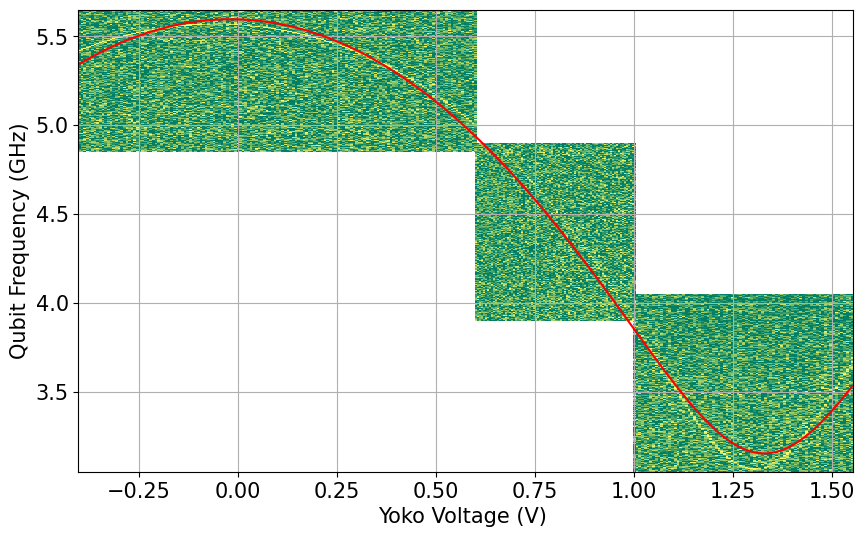

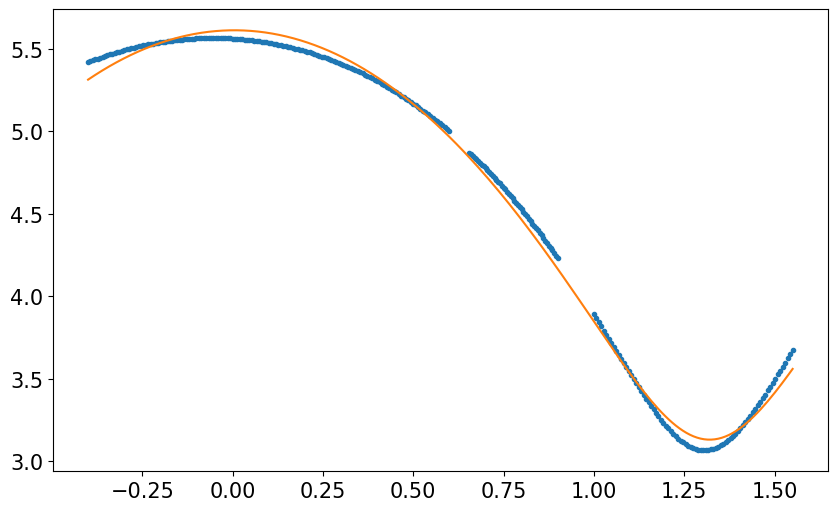

[4.97284346e-03 2.63084924e+00 3.18139256e-01 5.06417415e+01]


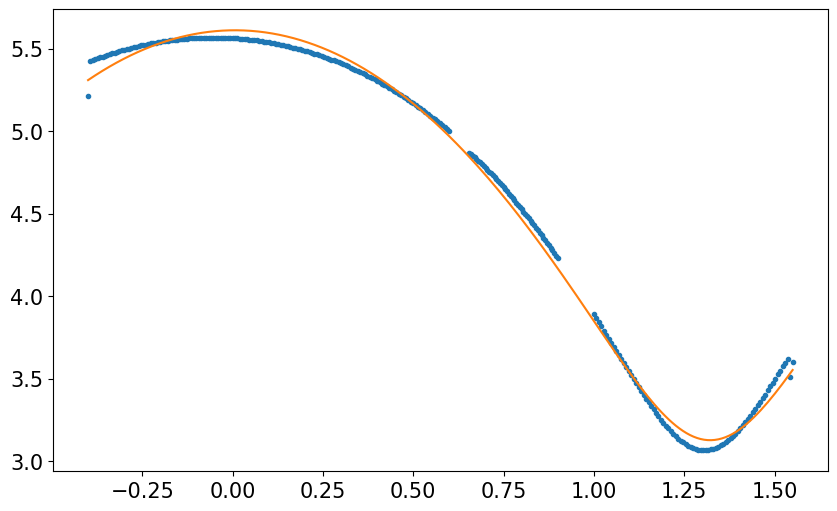

[6.66260430e-03 2.63030545e+00 3.17764369e-01 5.05964450e+01]
fp [6.66260430e-03 2.63030545e+00 3.17764369e-01 5.05964450e+01]


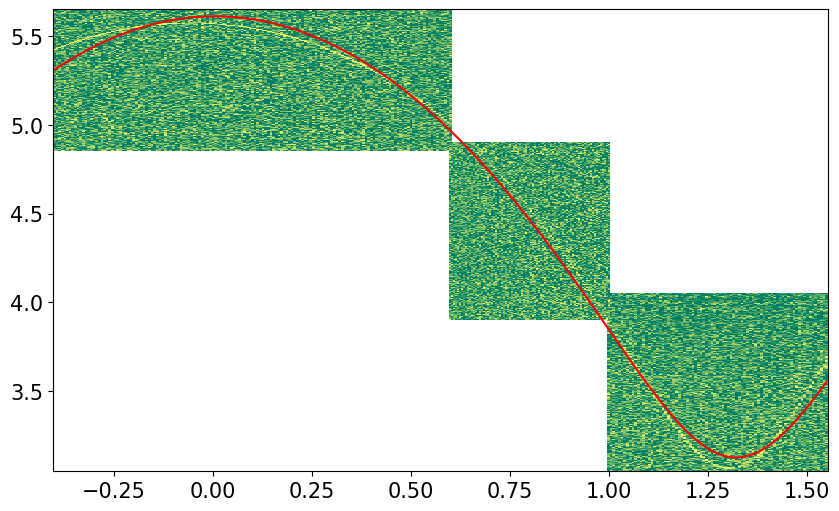

In [116]:
file_names = ['Z://QSimMeasurements/Measurements/4Q_Triangle_Lattice/pnax062824/2Tone4Qubit_NR_20240628_2056.mat', 
             'Z://QSimMeasurements/Measurements/4Q_Triangle_Lattice/pnax062824/2Tone4Qubit_NR_20240628_2210.mat', 
             'Z://QSimMeasurements/Measurements/4Q_Triangle_Lattice/pnax062824/2Tone4Qubit_NR_20240628_2346.mat']

list_of_x1 = []
list_of_y1 = []
list_of_z1 = []

for file in file_names:
    X, Y, Z = get_data(file)
    list_of_x1.append(X)
    list_of_y1.append(Y)
    list_of_z1.append(Z)
voltage_axis = voltage_axis_generator(list_of_x1)

xlim_center = -0.7
xlim_span = 0.5

ylim_center = 5.6
ylim_span = 0.22346

vmin = -2
vmax = 10.0


fig = plt.figure(10, figsize=[10, 6])
ax = fig.add_subplot(111)

for i in range(len(list_of_x1)):
    imshow(list_of_x1[i], list_of_y1[i], list_of_z1[i], vmin, vmax)
    
fits, frequency_max, v_total = Initial_Guesses(list_of_x1, list_of_y1, list_of_z1, [0, 0, 0], [None, None, None])

# fits[2] += -0.01
# fits[3] += -1.2
frequency = [fit_function(v, fits[0], fits[1], fits[2], fits[3]) for v in voltage_axis]
plt.plot(voltage_axis, frequency, color = 'red')
# plt.xlim(xlim_center - xlim_span / 2, xlim_center + xlim_span / 2)
# plt.ylim(ylim_center - ylim_span / 2, ylim_center + ylim_span / 2)

ax.grid(which='major', axis='both', linestyle='-')
plt.xlabel(r'Yoko Voltage (V) ')
plt.ylabel('Qubit Frequency (GHz)')
plt.show()

fp = fit_parameters(fits, list_of_x1, list_of_y1, list_of_z1, [0, 11, 0], [None, -20, None], spans = [200, 100])
print('fp', fp)

central_flux_4, flux_quanta_4, di_4, EjEc_4 = fp

fig = plt.figure(10, figsize=[10, 6])
ax = fig.add_subplot(111)

for i in range(len(list_of_x1)):
    imshow(list_of_x1[i], list_of_y1[i], list_of_z1[i], vmin, vmax)
frequency = [fit_function(v, fp[0], fp[1], fp[2], fp[3]) for v in voltage_axis]
plt.plot(voltage_axis, frequency, color = 'red')
plt.show()

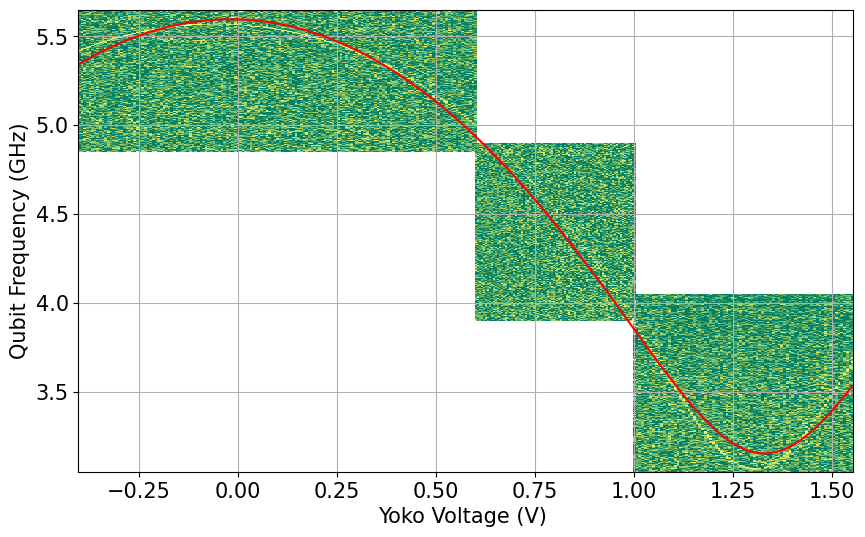

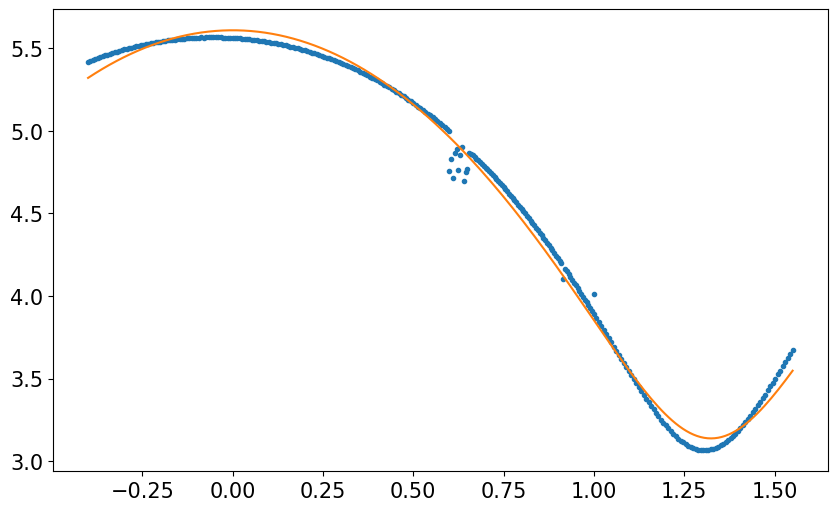

[3.13660591e-04 2.64742674e+00 3.20106055e-01 5.05647326e+01]


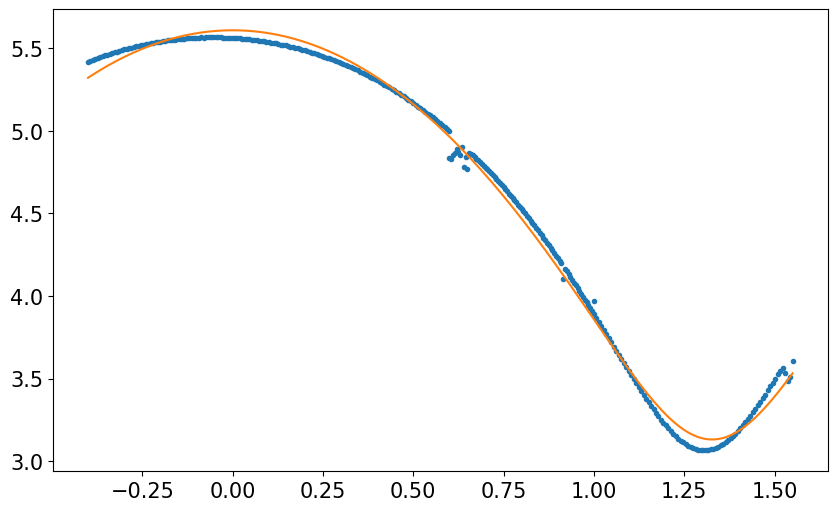

[4.53303867e-04 2.65364710e+00 3.18778973e-01 5.05657028e+01]


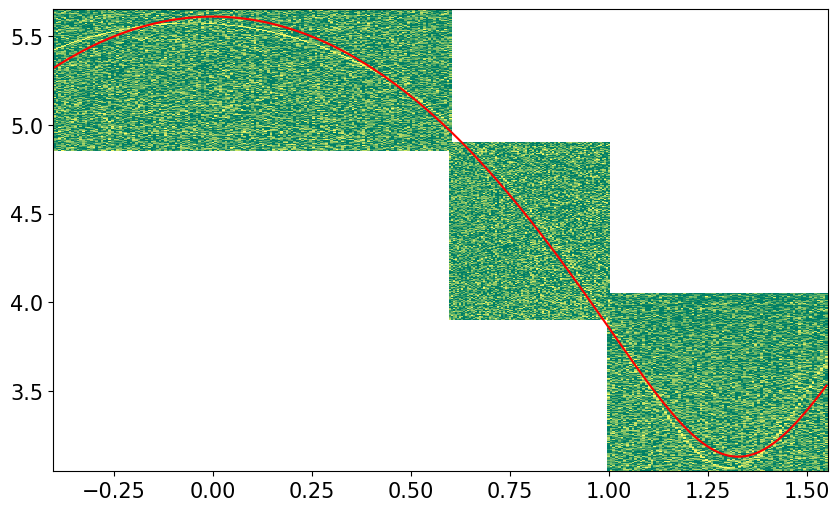

In [61]:
X1, Y1, Z1 = get_data('Z://QSimMeasurements/Measurements/4Q_Triangle_Lattice/pnax062824/2Tone4Qubit_NR_20240628_2056.mat')
X13, Y13, Z13 = get_data('Z://QSimMeasurements/Measurements/4Q_Triangle_Lattice/pnax062824/2Tone4Qubit_NR_20240628_2210.mat')

X12, Y12, Z12 = get_data('Z://QSimMeasurements/Measurements/4Q_Triangle_Lattice/pnax062824/2Tone4Qubit_NR_20240628_2346.mat')


list_of_x1 = [X1, X12, X13]
list_of_y1 = [Y1, Y12, Y13]
list_of_z1 = [Z1, Z12, Z13]
voltage_axis = voltage_axis_generator(list_of_x1)

xlim_center = -0.7
xlim_span = 0.5

ylim_center = 5.6
ylim_span = 0.22346

vmin = -2
vmax = 10.0


fig = plt.figure(10, figsize=[10, 6])
ax = fig.add_subplot(111)

for i in range(len(list_of_x1)):
    imshow(list_of_x1[i], list_of_y1[i], list_of_z1[i], vmin, vmax)
    
fits, frequency_max, v_total = Initial_Guesses(list_of_x1, list_of_y1, list_of_z1, [0, 0, 0], [None, None, None])

# fits[2] += -0.01
# fits[3] += -1.2
frequency = [fit_function(v, fits[0], fits[1], fits[2], fits[3]) for v in voltage_axis]
plt.plot(voltage_axis, frequency, color = 'red')
# plt.xlim(xlim_center - xlim_span / 2, xlim_center + xlim_span / 2)
# plt.ylim(ylim_center - ylim_span / 2, ylim_center + ylim_span / 2)

ax.grid(which='major', axis='both', linestyle='-')
plt.xlabel(r'Yoko Voltage (V) ')
plt.ylabel('Qubit Frequency (GHz)')
plt.show()

central_flux_4, flux_quanta_4, di_4, EjEc_4 = fit_parameters(fits, list_of_x1, list_of_y1, 
                                                             list_of_z1, [0, 0, 0], [None, None, None], spans = [200, 100])


fig = plt.figure(10, figsize=[10, 6])
ax = fig.add_subplot(111)

for i in range(len(list_of_x1)):
    imshow(list_of_x1[i], list_of_y1[i], list_of_z1[i], vmin, vmax)
frequency = [fit_function(v, central_flux_4, flux_quanta_4, di_4, EjEc_4) for v in voltage_axis]
plt.plot(voltage_axis, frequency, color = 'red')
plt.show()

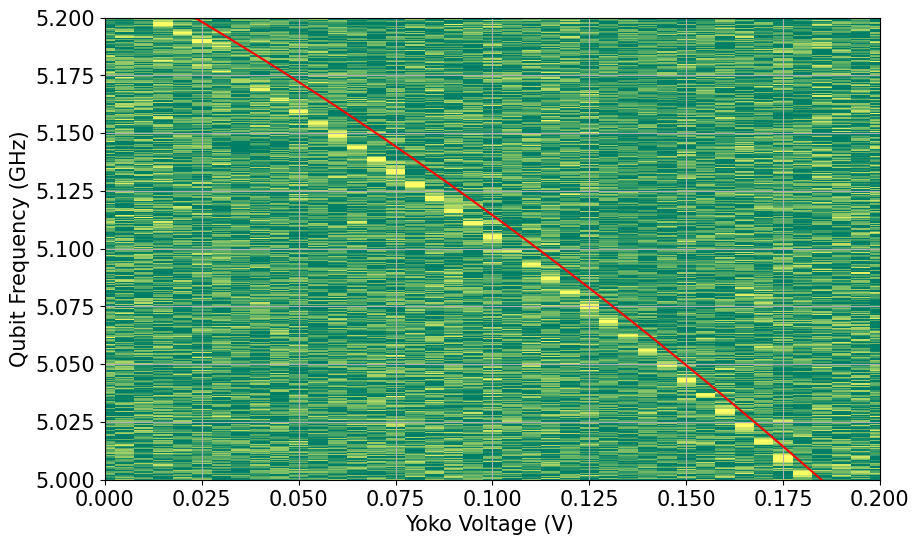

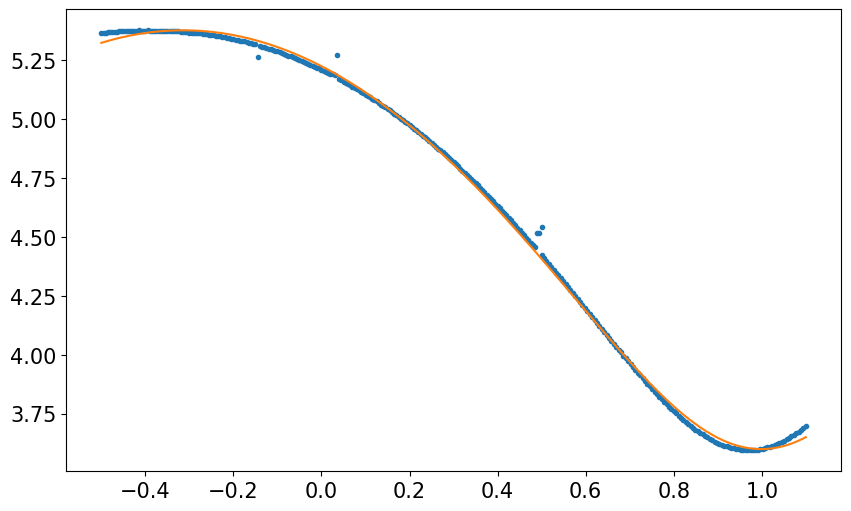

[-0.31451281  2.62606949  0.45478345 46.52723441]


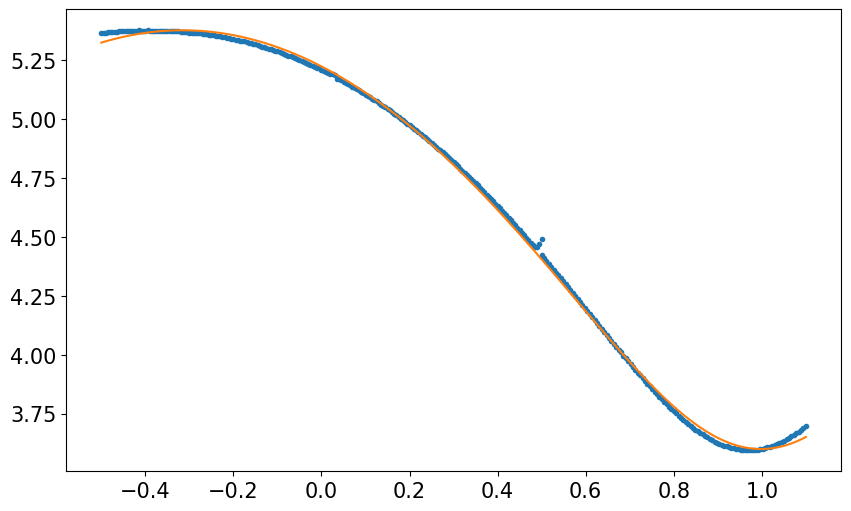

[-0.31581445  2.62764821  0.45482646 46.53011002]


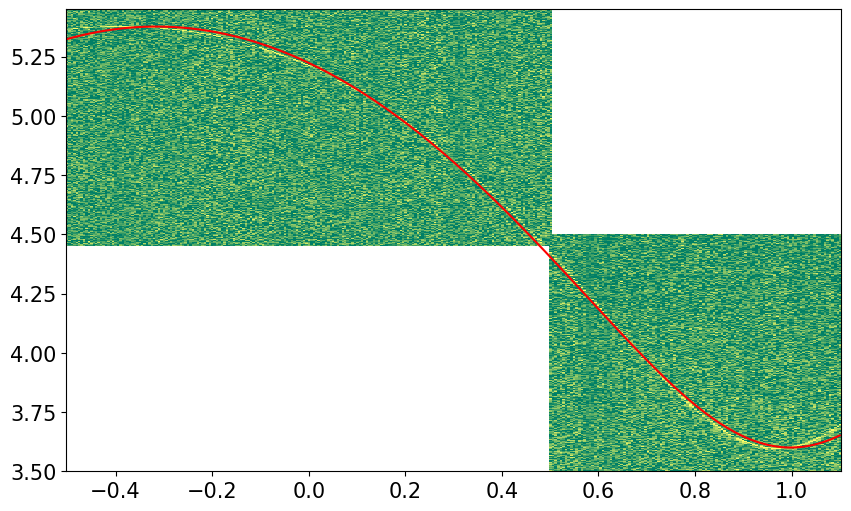

In [62]:
X1, Y1, Z1 = get_data('Z://QSimMeasurements/Measurements/4Q_Triangle_Lattice/pnax062724/2Tone4Qubit_NR_20240627_0803.mat')
X13, Y13, Z13 = get_data('Z://QSimMeasurements/Measurements/4Q_Triangle_Lattice/pnax062724/2Tone4Qubit_NR_20240627_0915.mat')


list_of_x1 = [X1, X13]
list_of_y1 = [Y1, Y13]
list_of_z1 = [Z1, Z13]
voltage_axis = voltage_axis_generator(list_of_x1)

xlim_center = 0.1
xlim_span = 0.2

ylim_center = 5.1
ylim_span = 0.2

vmin = -2
vmax = 10.0


fig = plt.figure(10, figsize=[10, 6])
ax = fig.add_subplot(111)

for i in range(len(list_of_x1)):
    imshow(list_of_x1[i], list_of_y1[i], list_of_z1[i], vmin, vmax)
    
fits, frequency_max, v_total = Initial_Guesses(list_of_x1, list_of_y1, list_of_z1, [0, 0, 0], [None, None, None])

# fits[2] += -0.01
# fits[3] += -1.2
frequency = [fit_function(v, fits[0], fits[1], fits[2], fits[3]) for v in voltage_axis]
plt.plot(voltage_axis, frequency, color = 'red')
plt.xlim(xlim_center - xlim_span / 2, xlim_center + xlim_span / 2)
plt.ylim(ylim_center - ylim_span / 2, ylim_center + ylim_span / 2)

ax.grid(which='major', axis='both', linestyle='-')
plt.xlabel(r'Yoko Voltage (V) ')
plt.ylabel('Qubit Frequency (GHz)')
plt.show()

central_flux_3, flux_quanta_3, di_3, EjEc_3 = fit_parameters(fits, list_of_x1, list_of_y1, 
                                                             list_of_z1, [0, 0, 0], [None, None, None], spans = [100, 50])


fig = plt.figure(10, figsize=[10, 6])
ax = fig.add_subplot(111)

for i in range(len(list_of_x1)):
    imshow(list_of_x1[i], list_of_y1[i], list_of_z1[i], vmin, vmax)
frequency = [fit_function(v, central_flux_3, flux_quanta_3, di_3, EjEc_3) for v in voltage_axis]
plt.plot(voltage_axis, frequency, color = 'red')
plt.show()

[-0.31581445, 2.62764821, 0.45482646, 46.53011002]


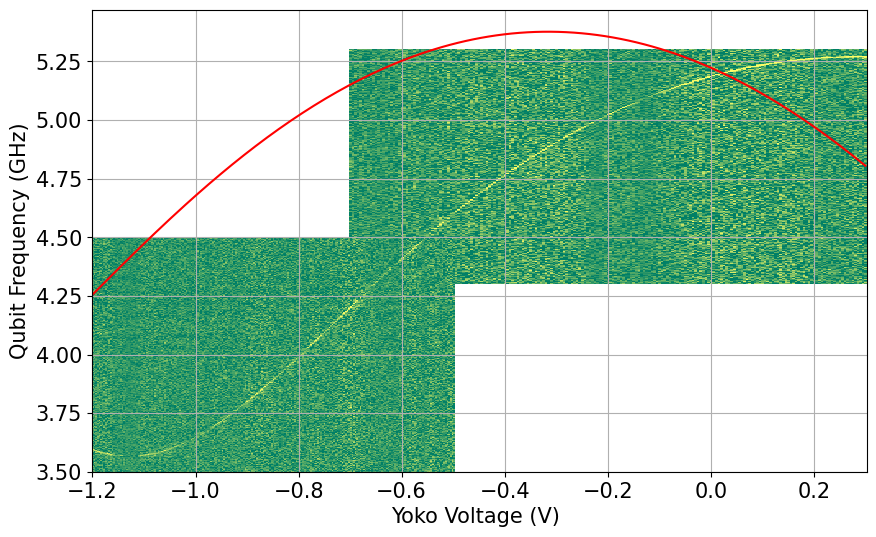

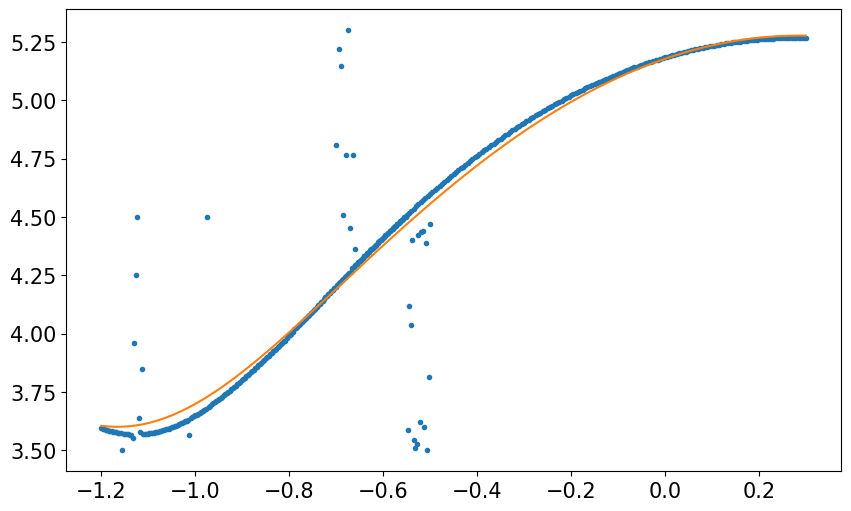

[ 0.28633675  2.90429396  0.47200027 44.8434155 ]


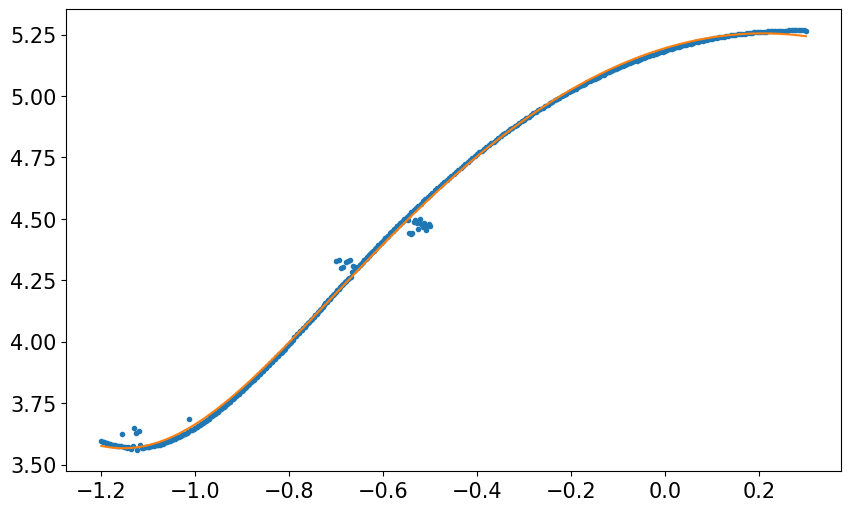

[ 0.20842145  2.72431177  0.46717987 44.4700732 ]


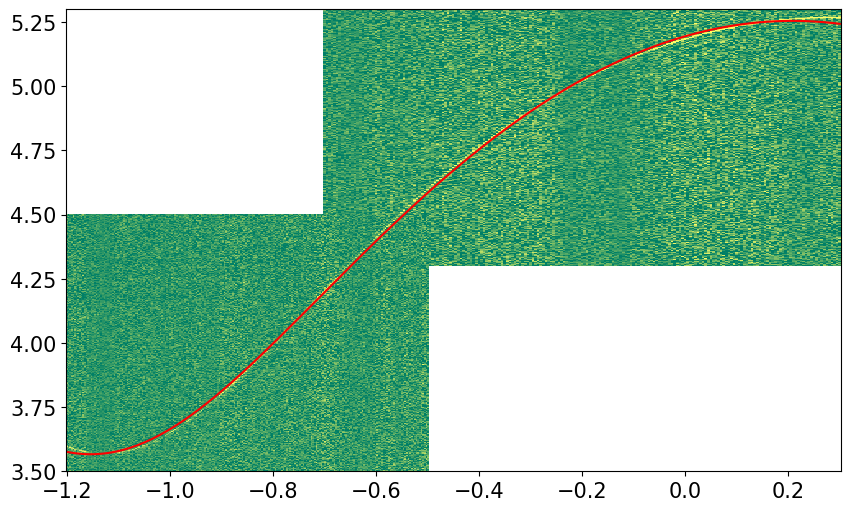

In [67]:
X1, Y1, Z1 = get_data('Z://QSimMeasurements/Measurements/4Q_Triangle_Lattice/pnax062724/2Tone4Qubit_NR_20240627_1348.mat')
X13, Y13, Z13 = get_data('Z://QSimMeasurements/Measurements/4Q_Triangle_Lattice/pnax062724/2Tone4Qubit_NR_20240627_1602.mat')


list_of_x1 = [X1, X13]
list_of_y1 = [Y1, Y13]
list_of_z1 = [Z1, Z13]
voltage_axis = voltage_axis_generator(list_of_x1)

xlim_center = -0.8
xlim_span = 0.05

ylim_center = 4
ylim_span = 0.05

vmin = -2
vmax = 10.0


fig = plt.figure(10, figsize=[10, 6])
ax = fig.add_subplot(111)

for i in range(len(list_of_x1)):
    imshow(list_of_x1[i], list_of_y1[i], list_of_z1[i], vmin, vmax)
    
fits, frequency_max, v_total = Initial_Guesses(list_of_x1, list_of_y1, list_of_z1, [0, 0, 0], [None, None, None])

fits = [-0.31581445,  2.62764821,  0.45482646, 46.53011002]
print(fits)
# fits[1] = -0.01
# fits[3] += -1.2
frequency = [fit_function(v, fits[0], fits[1], fits[2], fits[3]) for v in voltage_axis]
plt.plot(voltage_axis, frequency, color = 'red')
# plt.xlim(xlim_center - xlim_span / 2, xlim_center + xlim_span / 2)
# plt.ylim(ylim_center - ylim_span / 2, ylim_center + ylim_span / 2)

ax.grid(which='major', axis='both', linestyle='-')
plt.xlabel(r'Yoko Voltage (V) ')
plt.ylabel('Qubit Frequency (GHz)')
plt.show()

central_flux_2, flux_quanta_2, di_2, EjEc_2 = fit_parameters(fits, list_of_x1, list_of_y1, 
                                                             list_of_z1, [0, 0, 0], [None, None, None], spans = [1000, 50])


fig = plt.figure(10, figsize=[10, 6])
ax = fig.add_subplot(111)

for i in range(len(list_of_x1)):
    imshow(list_of_x1[i], list_of_y1[i], list_of_z1[i], vmin, vmax)
frequency = [fit_function(v, central_flux_2, flux_quanta_2, di_2, EjEc_2) for v in voltage_axis]
plt.plot(voltage_axis, frequency, color = 'red')
plt.show()

In [75]:
#Qubit 2
Voltage_2 = -0.2
print(fit_function(Voltage_2, central_flux_2, flux_quanta_2, di_2, EjEc_2))

5.025869902103384


In [77]:
#Qubit 3
Voltage_3 = 0.3
print(fit_function(Voltage_3, central_flux_3, flux_quanta_3, di_3, EjEc_3))

4.805383213008741


In [70]:
#Qubit 4
Voltage_4 = 0
print(fit_function(Voltage_4, central_flux_4, flux_quanta_4, di_4, EjEc_4))

5.6087648590452055


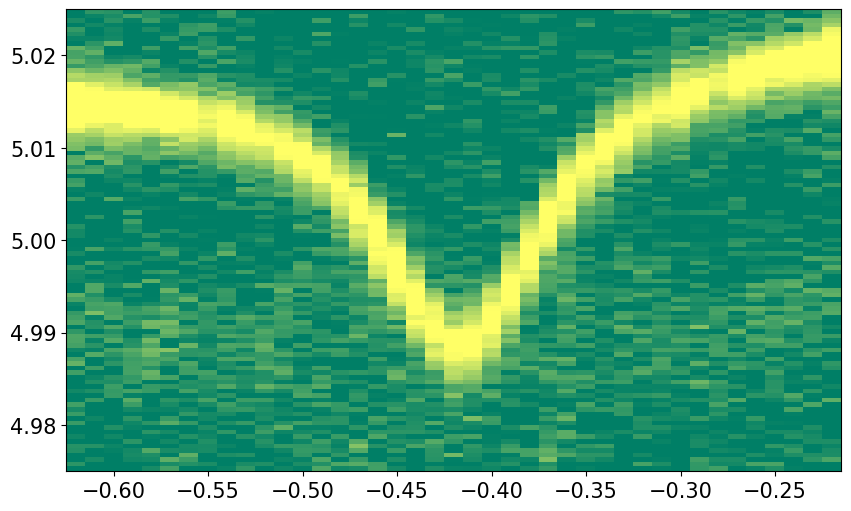

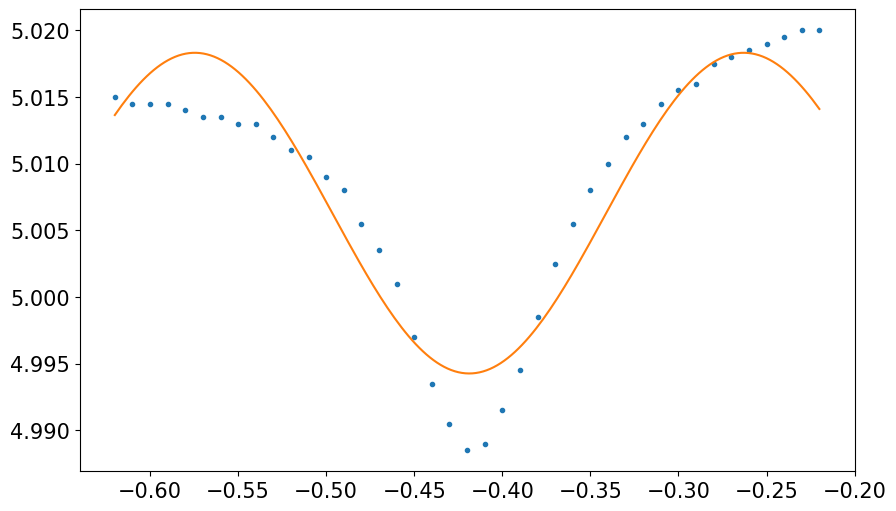

[ 0.04865786  0.31162744  0.99058707 40.61373143]


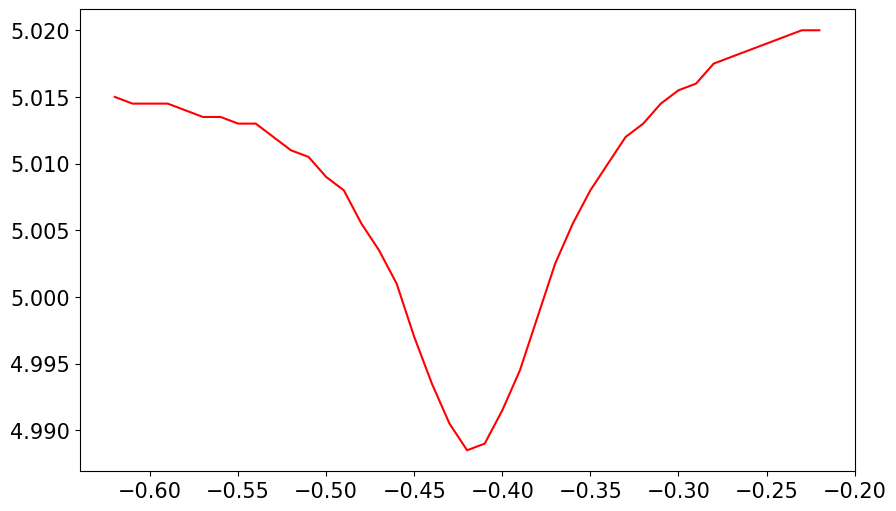

In [92]:
X13, Y13, Z13 = get_data('Z://QSimMeasurements/Measurements/4Q_Triangle_Lattice/pnax070124/2Tone4Qubit_NR_20240701_1440.mat')


list_of_x1 = [X13]
list_of_y1 = [Y13]
list_of_z1 = [Z13]
voltage_axis = voltage_axis_generator(list_of_x1)

xlim_center = -0.8
xlim_span = 0.05

ylim_center = 4
ylim_span = 0.05

vmin = -2
vmax = 10.0


fig = plt.figure(10, figsize=[10, 6])
ax = fig.add_subplot(111)

for i in range(len(list_of_x1)):
    imshow(list_of_x1[i], list_of_y1[i], list_of_z1[i], vmin, vmax)
plt.show()
    
fits = [1, 1, 1, 1]


Voltages_34, frequencies_34 = fit_parameters(fits, list_of_x1, list_of_y1, 
                                                             list_of_z1, [0, 0, 0], [None, None, None], spans = [1000], 
                                                            return_freqs = True)


fig = plt.figure(10, figsize=[10, 6])
ax = fig.add_subplot(111)
plt.plot(Voltages_34, frequencies_34, color = 'red')
plt.show()

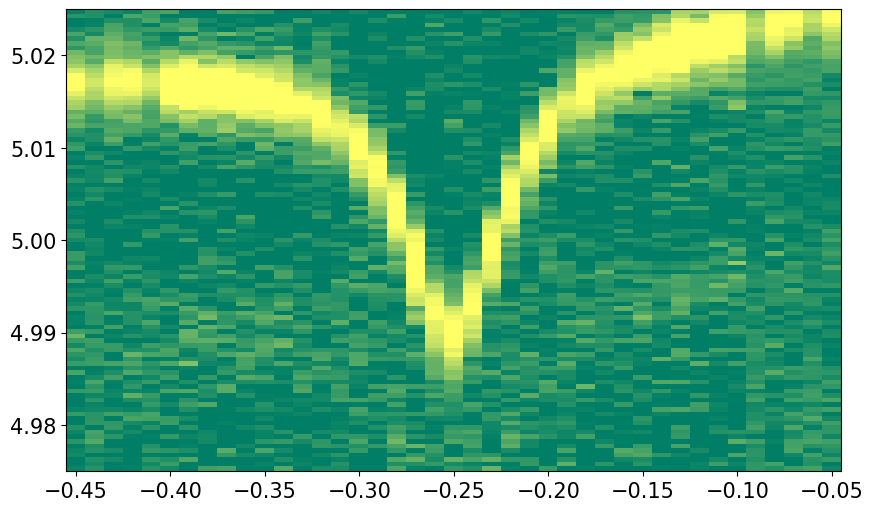

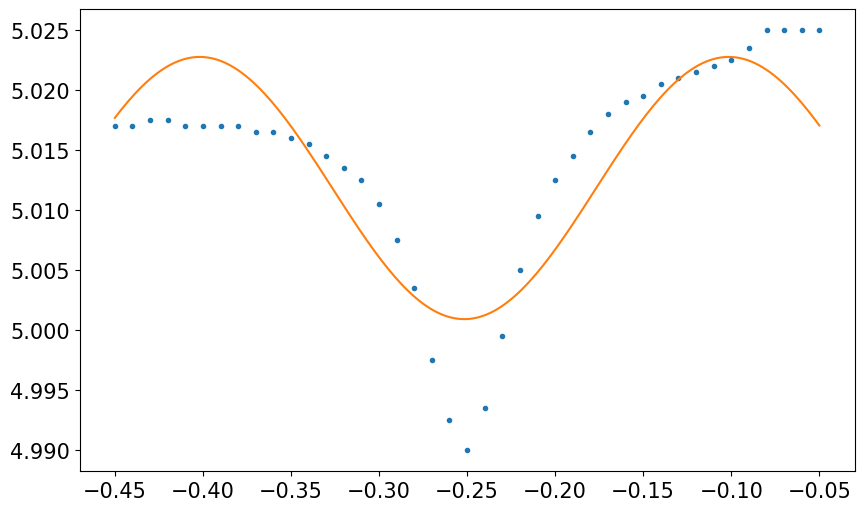

[ 0.3490151   0.30031396  1.00861965 40.33723819]


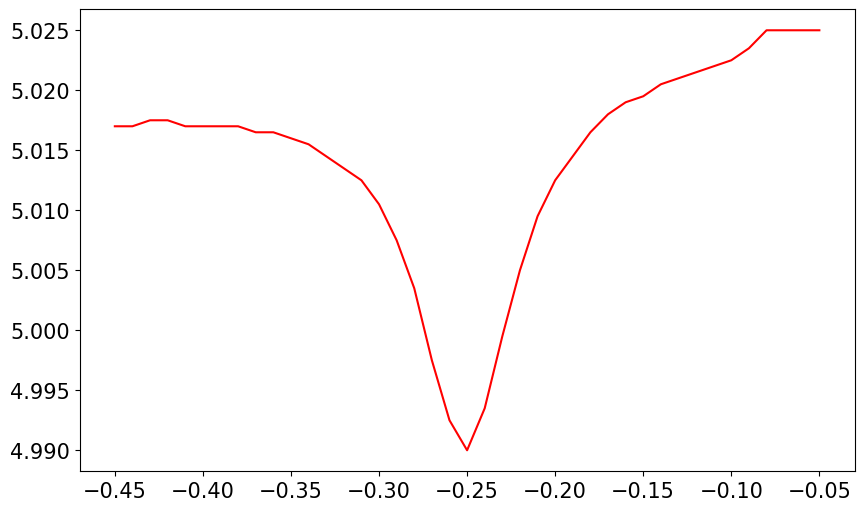

In [93]:
X13, Y13, Z13 = get_data('Z://QSimMeasurements/Measurements/4Q_Triangle_Lattice/pnax070124/2Tone4Qubit_NR_20240701_1456.mat')


list_of_x1 = [X13]
list_of_y1 = [Y13]
list_of_z1 = [Z13]
voltage_axis = voltage_axis_generator(list_of_x1)

xlim_center = -0.8
xlim_span = 0.05

ylim_center = 4
ylim_span = 0.05

vmin = -2
vmax = 10.0


fig = plt.figure(10, figsize=[10, 6])
ax = fig.add_subplot(111)

for i in range(len(list_of_x1)):
    imshow(list_of_x1[i], list_of_y1[i], list_of_z1[i], vmin, vmax)
plt.show()
    
fits = [1, 1, 1, 1]


Voltages_24, frequencies_24 = fit_parameters(fits, list_of_x1, list_of_y1, 
                                                             list_of_z1, [0, 0, 0], [None, None, None], spans = [1000], 
                                                            return_freqs = True)


fig = plt.figure(10, figsize=[10, 6])
ax = fig.add_subplot(111)
plt.plot(Voltages_24, frequencies_24, color = 'red')
plt.show()

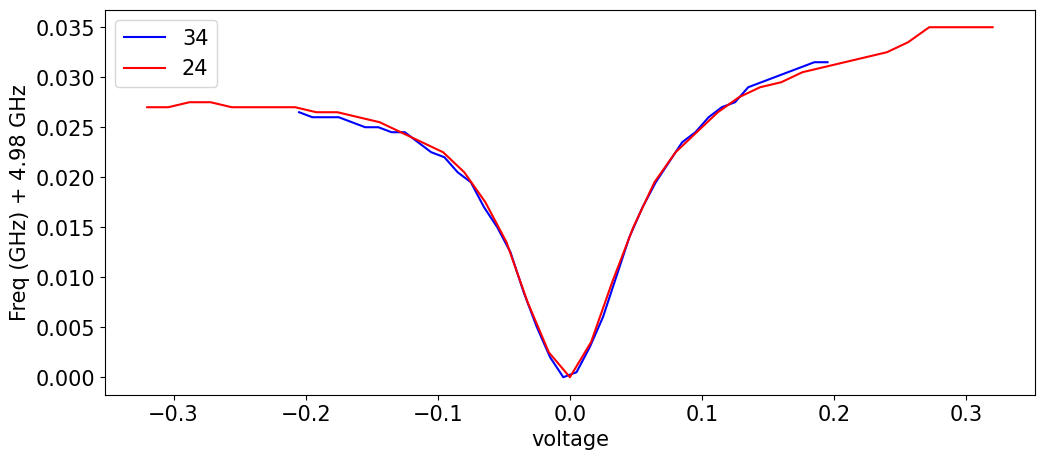

In [107]:
mult_factor = 1.6
plt.plot(np.array(Voltages_34) + 0.415, np.array(frequencies_34) - min(frequencies_34), color = 'blue', label = '34')
plt.plot((np.array(Voltages_24) + 0.25) * mult_factor, np.array(frequencies_24) - min(frequencies_24), color = 'red', label = '24')
plt.legend()
plt.xlabel('voltage')
plt.ylabel('Freq (GHz) + 4.98 GHz')

plt.show()

In [ ]:
Cross talk matrix! Lets goooooooooooooooo



Idea- voltage in one line correcponds to what offset voltage in the other?

In [ ]:
M * V + offset = (flux)

In [ ]:
1/F1, (slope_cross_21 / flux_q1 * slope_1)
slope_12/flux2 * slope_2, 1/F2

* 

Start reading qubit 4 (bc very nice resonator!)



Q: How much voltage in one corresponds to how much voltage in the other?
    
    Voltage down one line means how much should I compensate it 

    M * V

In [7]:
wc1 = 0.5
wc2 = 0.5 * 1

g = 0.10

H = np.array([[wc1, g, 0], [g, 0, g], [0, g, wc2]])
print(g**2 / wc1)
print(g**2 / 0.5372)

np.round(np.sort(np.linalg.eig(H)[0]), 4)

0.020000000000000004
0.0186150409530901


array([-0.0372,  0.5   ,  0.5372])